# Harness XGBoost’s optimized gradient boosting trees for high-accuracy regression with efficient training.

### Imports & data loading

In [127]:
import time
import numpy as np
import joblib
import warnings
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import optuna

warnings.filterwarnings('ignore')

# 1) Load your preprocessed splits
X_train, y_train = joblib.load("data/processed/train.pkl")
X_val,   y_val   = joblib.load("data/processed/val.pkl")
X_test,  y_test  = joblib.load("data/processed/test.pkl")

# 2) (Optional) Merge train+val for final fitting
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

# 3) Build DMatrix objects once
dtrain      = xgb.DMatrix(X_train,       label=y_train)
dval        = xgb.DMatrix(X_val,         label=y_val)
dtrain_full = xgb.DMatrix(X_train_full,  label=y_train_full)
dtest       = xgb.DMatrix(X_test,        label=y_test)

### Baseline XGBoost via xgb.train()

In [100]:
baseline_params = {
    "objective":        "reg:squarederror",
    "learning_rate":    0.05,
    "max_depth":        8,
    "subsample":        1.0,
    "colsample_bytree": 1.0,
    "tree_method":      "hist",
    "seed":             42,
    "eval_metric":      "rmse",
}

t0 = time.time()
bst_baseline = xgb.train(
    params                = baseline_params,
    dtrain                = dtrain,
    num_boost_round       = 1000,
    evals                 = [(dval, "valid")],
    early_stopping_rounds = 50,
    verbose_eval          = False,
)
baseline_train_time = time.time() - t0

# predict on test, up to best_iteration
t1 = time.time()
y_pred_base = bst_baseline.predict(dtest,
                                   iteration_range=(0, bst_baseline.best_iteration))
pred_time_base = time.time() - t1

test_rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
test_r2_base   = r2_score(y_test, y_pred_base)

print("🏁 Baseline XGBoost")
print(f"⏱  Train time   : {baseline_train_time:.2f}s")
print(f"🔍 Test RMSE    : {test_rmse_base:,.2f}")
print(f"📈 Test R²      : {test_r2_base:.3f}")
print(f"⏱  Predict time : {pred_time_base:.3f}s for {len(X_test)} samples")

🏁 Baseline XGBoost
⏱  Train time   : 3.63s
🔍 Test RMSE    : 6,449.31
📈 Test R²      : 0.926
⏱  Predict time : 0.085s for 43165 samples


Using default xgb.train parameters (1 000 rounds, early stopping on validation after 50 rounds), XGBoost already outperforms LightGBM’s baseline by about 350 RMSE and gains ~0.008 in R².

### Optuna objective using xgb.train()

In [101]:
def objective(trial):
    params = {
      "objective":        "reg:squarederror",
      "learning_rate":    trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
      "max_depth":        trial.suggest_int("max_depth", 3, 12),
      "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
      "tree_method":      "hist",
      "seed":             42,
      "eval_metric":      "rmse",
    }
    num_round = trial.suggest_int("n_estimators", 100, 1000)

    bst = xgb.train(
      params                = params,
      dtrain                = dtrain,
      num_boost_round       = num_round,
      evals                 = [(dval, "valid")],
      early_stopping_rounds = 50,
      verbose_eval          = False,
    )
    preds = bst.predict(dval,
                        iteration_range=(0, bst.best_iteration))
    # return validation RMSE
    return mean_squared_error(y_val, preds, squared=False)

### Run the Optuna study

In [104]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

[I 2025-05-24 14:59:05,021] A new study created in memory with name: no-name-c5174547-0221-42be-8d2f-fa2e65d3f6c6


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-24 14:59:10,996] Trial 0 finished with value: 8320.924439171651 and parameters: {'learning_rate': 0.02014431790817879, 'max_depth': 8, 'subsample': 0.9860056219143646, 'colsample_bytree': 0.8529593847228769, 'n_estimators': 750}. Best is trial 0 with value: 8320.924439171651.
[I 2025-05-24 14:59:12,307] Trial 1 finished with value: 14386.835529330796 and parameters: {'learning_rate': 0.01032445420464758, 'max_depth': 3, 'subsample': 0.932902863447185, 'colsample_bytree': 0.6083511458411721, 'n_estimators': 257}. Best is trial 0 with value: 8320.924439171651.
[I 2025-05-24 14:59:22,961] Trial 2 finished with value: 8976.547038212075 and parameters: {'learning_rate': 0.01226313715963767, 'max_depth': 12, 'subsample': 0.8628627048752285, 'colsample_bytree': 0.828419885586914, 'n_estimators': 856}. Best is trial 0 with value: 8320.924439171651.
[I 2025-05-24 14:59:28,811] Trial 3 finished with value: 8289.028935839624 and parameters: {'learning_rate': 0.013446419382707322, 'max_

In [111]:
auto_df = study.trials_dataframe()
print(auto_df.columns.tolist())

['number', 'value', 'datetime_start', 'datetime_complete', 'duration', 'params_colsample_bytree', 'params_learning_rate', 'params_max_depth', 'params_n_estimators', 'params_subsample', 'state']


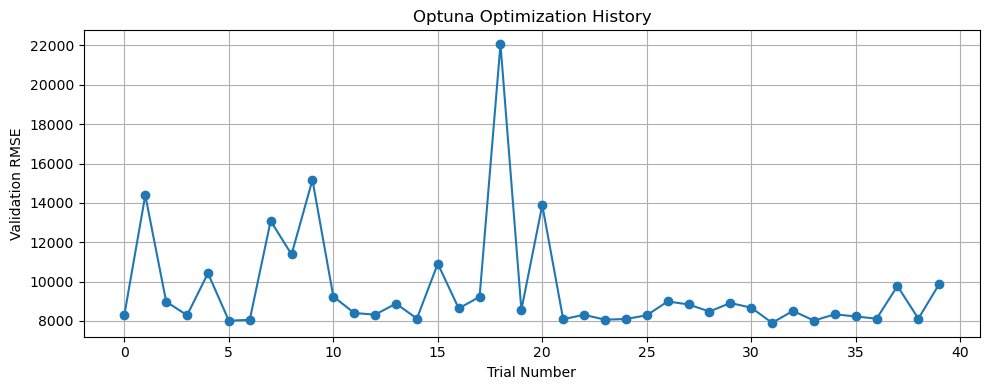

In [151]:
# 1) Optimization history

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(trials_df['number'], trials_df['value'], marker='o', linestyle='-')
plt.xlabel('Trial Number')
plt.ylabel('Validation RMSE')
plt.title('Optuna Optimization History')
plt.grid(True)
plt.tight_layout()
plt.show()

### Examine top trials

In [120]:
# 1) pull *everything* into a DataFrame
trials_df = study.trials_dataframe()

# 2) pick out the handful of columns we care about
keep = [
    "number",               # trial ID
    "value",                # objective (validation RMSE)
    "params_n_estimators",
    "params_learning_rate",
    "params_max_depth",
    "params_subsample",
    "params_colsample_bytree",
]
trials_df = trials_df[keep]

print("🔍 Top 5 Optuna Trials (validation RMSE):")
display(trials_df.nsmallest(5, "value"))

🔍 Top 5 Optuna Trials (validation RMSE):


,number,value,params_n_estimators,params_learning_rate,params_max_depth,params_subsample,params_colsample_bytree
31,31,7905.138812,594,0.069941,6,0.585095,0.756275
5,5,8012.020925,969,0.027880,7,0.755215,0.762105
33,33,8016.906625,498,0.042903,7,0.949289,0.845928
6,6,8056.019635,801,0.020371,7,0.891215,0.904330
23,23,8065.038057,796,0.027164,7,0.705588,0.798366


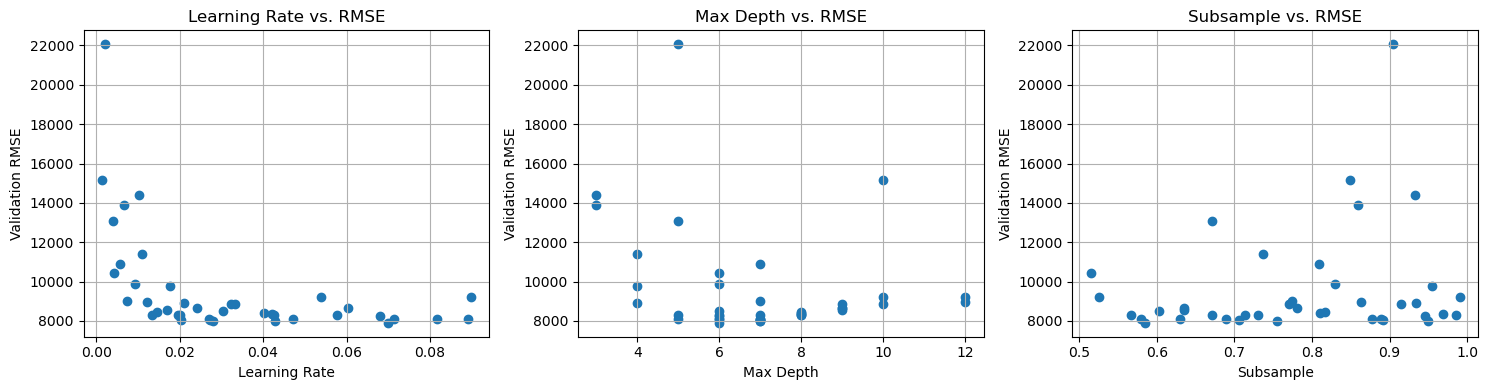

In [153]:
# 2) Hyperparameter vs. RMSE scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
params = ['params_learning_rate', 'params_max_depth', 'params_subsample']
titles = ['Learning Rate', 'Max Depth', 'Subsample']

for ax, param, title in zip(axes, params, titles):
    ax.scatter(trials_df[param], trials_df['value'])
    ax.set_xlabel(title)
    ax.set_ylabel('Validation RMSE')
    ax.set_title(f'{title} vs. RMSE')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Final “best” XGBoost on train+val

In [122]:
best = study.best_params
best_params = {
  "objective":        "reg:squarederror",
  "learning_rate":    best["learning_rate"],
  "max_depth":        best["max_depth"],
  "subsample":        best["subsample"],
  "colsample_bytree": best["colsample_bytree"],
  "tree_method":      "hist",
  "seed":             42,
  "eval_metric":      "rmse",
}
num_round = best["n_estimators"]

t2 = time.time()
bst_tuned = xgb.train(
  params                = best_params,
  dtrain                = dtrain_full,
  num_boost_round       = num_round,
  evals                 = [(dval, "valid")],
  early_stopping_rounds = 50,
  verbose_eval          = False,
)
tuned_train_time = time.time() - t2

# final predict
t3 = time.time()
y_pred_tuned = bst_tuned.predict(dtest,
                                 iteration_range=(0, bst_tuned.best_iteration))
pred_time_tuned = time.time() - t3

test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
test_r2_tuned   = r2_score(y_test, y_pred_tuned)

print("🏆 Tuned XGBoost + Optuna")
print(f"⏱  Train time   : {tuned_train_time:.2f}s")
print(f"🔍 Test RMSE    : {test_rmse_tuned:,.2f}")
print(f"📈 Test R²      : {test_r2_tuned:.3f}")
print(f"⏱  Predict time : {pred_time_tuned:.3f}s for {len(X_test)} samples")

🏆 Tuned XGBoost + Optuna
⏱  Train time   : 4.13s
🔍 Test RMSE    : 6,049.01
📈 Test R²      : 0.935
⏱  Predict time : 0.074s for 43165 samples


After 40 Optuna trials, the best XGBoost configuration cuts test RMSE by ~400 compared to its baseline, pushing R² up to 0.935. This is a significant margin over both the LightGBM baseline and its Optuna-tuned version.

Overall: XGBoost + Optuna yields the lowest test RMSE (≈6 049) and highest R² (≈0.935).
Training Speed: Although tuning increases XGBoost’s train time by ~0.5 s, its prediction remains extremely fast (0.074 s).